# Lecture 10 – Clustering Exercises

**Welcome to your hands-on notebook for Lecture 10!**

**Motivation:** Clustering load profiles reveals groups of similar energy usage patterns, enabling applications like demand response aggregation and DER detection in energy systems.

In this exercise notebook you will:
1. **Load and explore** 15-minute smart-meter data
2. **Engineer features** (domain-agnostic & domain-informed) and **Standardize** the feature matrix  
3. **Visualize** the feature space with t-SNE and PCA
4. **Cluster** load profiles using K-Means and Agglomerative (Ward)  
5. **Evaluate** clusters via silhouette scores and inertia  
6. **Interpret** cluster characteristics in terms of DER presence  
7. **Reflect** on your results and plan next steps  

## 1. Import Required Libraries

We begin by importing all Python packages needed throughout this notebook:

- **pandas**, **numpy** for data handling  
- **matplotlib** for plotting  
- **sklearn** modules for preprocessing, dimensionality reduction, clustering, and evaluation


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# packages for files handling and downloading
import os
import urllib.request

# packages for data processing and machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, classification_report
from scipy.stats import kurtosis

## 2. Load and Explore Data

Load the CSV of 15-minute consumption/injection data, inspect its shape, and plot two sample meters to get a feel for raw load profiles.

This dataset is part of the corpus of quarter hourly data from 1,300 residential buildings in Flanders (Belgium) made openly available for the year 2022 by Fluvius, the Flemish DSO. We will be using parts of this dataset during our lecture 10 through 12. 

**This cell will create an `inputs/` folder (if it doesn't already exist) and then download the `sample_smart_meter_data.parquet` file from the GitHub repository into that folder.**

> Note: Eventhough this is only a small part of the full dataset, it is still quite large and storing it in a CSV format would be inefficient. Therefore, we use the Parquet format, which is more efficient for large datasets. To read more about the Parquet format and how to load and save it, you can refer to Pandas documentation on [Parquet](https://pandas.pydata.org/docs/user_guide/io.html#parquet). But in a nutshell, Parquet is a columnar storage file format that is optimized for use with big data processing frameworks like Apache Spark and Hadoop. It is designed to be efficient for both reading and writing large datasets, and it supports advanced features like compression and schema evolution. And once it is loaded, you can work with it just like a regular Pandas DataFrame.

If you are running this notebook in Google Colab, Pyarrow is already installed, so you can directly read the Parquet file. If you are running this notebook locally, you may need to install the `pyarrow` package to read Parquet files. You can do this by running `pip install pyarrow` in your terminal or command prompt.

In [2]:
# 1) Create the 'inputs' folder if it doesn't exist
os.makedirs('inputs', exist_ok=True)

# 2) Define the URL to the raw CSV on GitHub and the local path
url = 'https://raw.githubusercontent.com/nick-harder/AIES/main/lecture10/data/sample_smart_meter_data.parquet'
local_path = 'inputs/sample_smart_meter_data.parquet'

# 3) Download the file only if it's not already present
if not os.path.exists(local_path):
    print(f"Downloading data from {url} ...")
    urllib.request.urlretrieve(url, local_path)
    print("Download complete.")
else:
    print("File already exists, skipping download.")

Download complete.


Dataset shape: (8760000, 4)
   Meter_ID           Timestamp  Consumption_kWh  Injection_kWh
0      1169 2022-01-01 00:00:00            0.088            0.0
1      1169 2022-01-01 00:15:00            0.067            0.0
2      1169 2022-01-01 00:30:00            0.085            0.0
3      1169 2022-01-01 00:45:00            0.067            0.0
4      1169 2022-01-01 01:00:00            0.068            0.0


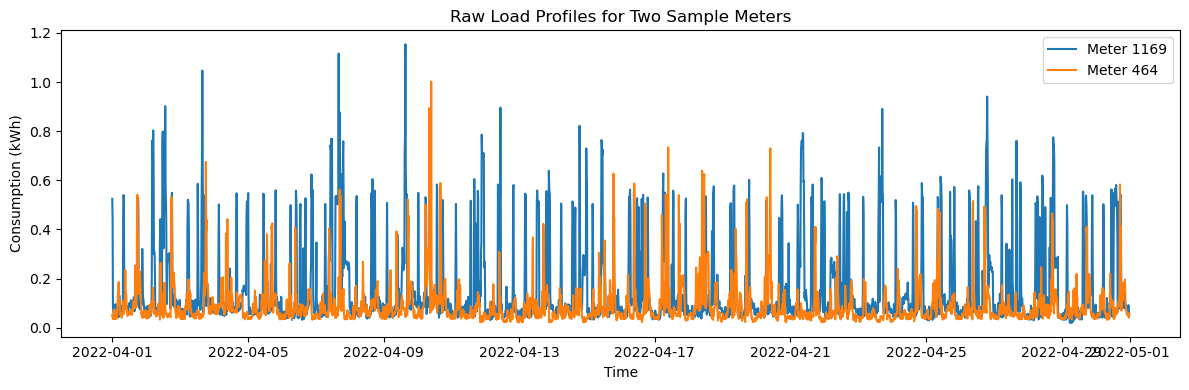

In [3]:
# 1.1 Load
df = pd.read_parquet(local_path).reset_index()
# parse timestamps
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# 1.2 Overview
print("Dataset shape:", df.shape)
print(df.head())

# 1.3 Plot two sample meters
sample_ids = df["Meter_ID"].unique()[:2]
plt.figure(figsize=(12,4))
for meter in sample_ids:
    series = df[df["Meter_ID"]==meter].set_index("Timestamp")["Consumption_kWh"]
    # select only April 2023 data
    series = series[series.index.month == 4]
    plt.plot(series.index, series.values, label=f"Meter {meter}")
plt.legend()
plt.title("Raw Load Profiles for Two Sample Meters")
plt.xlabel("Time")
plt.ylabel("Consumption (kWh)")
plt.tight_layout()
plt.show()

We also fix the random seed for reproducibility.

In [4]:
random_seed = 42


## 3. Domain-Agnostic Feature Extraction

We compute basic statistical features over each meter’s full time series and link them to physical insights:

- **Mean**: average consumption (baseline usage level)  
- **Standard deviation**: variability (load volatility)  
- **Skewness**: asymmetry (peak vs. off-peak behavior)  
- **Kurtosis**: peakedness (extreme events)  
- **Autocorrelation** at lag 1 and lag 24: temporal persistence (daily repeatability) 

In [5]:
def compute_mean(x):
    return x.mean()

def compute_std(x):
    return x.std()

def compute_skewness(x):
    return x.skew()

def impute_missing(x):
    return x.ffill().bfill()

### 3.1 Exercise 1: Implement Kurtosis and Autocorrelation
Implement the kurtosis and autocorrelation features in the `extract_features` function. Use `scipy.stats.kurtosis` for kurtosis and `pandas.Series.autocorr` for autocorrelation. Ensure you compute autocorrelation for both lag 1 and lag 24.

In [6]:
def compute_kurtosis(x):
    # fisher=True returns excess kurtosis (normal dist -> 0), nan_policy='omit' ignores NaNs
    return float(kurtosis(x, fisher=True, nan_policy='omit'))

def compute_autocorr(x, lag):
    # pandas.Series.autocorr handles missing values internally
    return float(x.autocorr(lag=lag))


## 4. Domain-Informed Feature Extraction

These metrics capture patterns linked to DER presence (PV panels, EV charging):

- **Midday Dip**: drop around 12–14 h (PV generation reduces net consumption)  
- **Evening Ramp**: increase 18–21 h vs. 15–18 h (EV charging starts)  
- **Night/Day Ratio**: avg. load 00–06 h ÷ 06–18 h (overnight appliances)  
- **Weekend Load Factor**: avg. weekend ÷ weekday (occupancy patterns)  
- **Peak-to-Average Ratio**: peak demand ÷ mean (device spikes)  
- **Longest Period Above Mean**: continuous high-load streaks (e.g. heating)  
- **Longest Period of Successive Increase**: sustained rises (e.g. EV charging session)  

In [7]:
def compute_midday_dip(x):
    """
    Measures how much the consumption drops during midday hours (12:00–14:00)
    relative to the overall average.

    A pronounced dip could suggest solar PV generation reducing net load.
    """
    midday = x.between_time("12:00", "14:00").mean()
    return midday - x.mean()


def compute_evening_ramp(x):
    """
    Measures the increase in consumption from afternoon (15:00–18:00)
    to evening hours (18:00–21:00).

    A steep evening ramp may indicate the start of EV charging or cooking activity.
    """
    eve = x.between_time("18:00", "21:00").mean()
    aft = x.between_time("15:00", "18:00").mean()
    return eve - aft


def compute_night_day_ratio(x):
    """
    Computes the ratio of average night-time load (00:00–06:00)
    to average day-time load (06:00–18:00).

    This feature helps detect households with high overnight usage (e.g., EV charging).
    """
    night = x.between_time("00:00", "06:00").mean()
    day = x.between_time("06:00", "18:00").mean()
    return night / day


def compute_weekend_load_factor(x):
    """
    Calculates the ratio of weekend average load to weekday average load.

    Useful to detect occupancy patterns—e.g., higher weekend usage could indicate
    a home-based lifestyle or weekend charging.
    """
    wknd = x[x.index.dayofweek >= 5].mean()  # Saturday=5, Sunday=6
    wkday = x[x.index.dayofweek < 5].mean()  # Monday–Friday
    return wknd / wkday


def compute_peak_to_avg(x):
    """
    Ratio of peak load to average load across the entire time series.

    High values indicate "spikiness"—typically associated with event-driven loads like EV charging.
    """
    return x.max() / x.mean()


def compute_longest_above_mean(x):
    """
    Computes the longest consecutive time period during which consumption remains
    above the mean level.

    Long high-usage periods may indicate appliances with sustained load, such as HVAC or EVs.
    """
    threshold = x.mean()
    mask = x > threshold

    # If no values exceed the mean, return 0
    if not mask.any():
        return 0

    # Identify contiguous runs above the threshold
    runs = (mask != mask.shift()).cumsum()
    lengths = mask.groupby(runs).sum()
    return int(lengths.max())


def compute_longest_increase_streak(x):
    """
    Finds the longest sequence of strictly increasing consumption values
    in the time series.

    Can indicate gradual ramp-up behavior, such as slow EV charging or heat pump cycles.
    """
    delta = x.diff()
    mask = delta > 0

    if not mask.any():
        return 0

    runs = (mask != mask.shift()).cumsum()
    lengths = mask.groupby(runs).sum()
    return int(lengths.max())


## 5. Prepare Features

### 5.1 Build Feature Matrix

Apply both sets of functions to each meter to assemble a feature DataFrame.

In [8]:
# Refactored: modular feature extraction
def extract_features(df, meter_id):
    series = df[df["Meter_ID"]==meter_id].set_index("Timestamp")["Consumption_kWh"]
    series = impute_missing(series)
    return {
        "Meter_ID": meter_id,
        "mean": compute_mean(series),
        "std": compute_std(series),
        "skew": compute_skewness(series),
        "kurtosis": compute_kurtosis(series),
        "autocorr_lag1": compute_autocorr(series,1),
        "autocorr_lag24": compute_autocorr(series,24),
        "midday_dip": compute_midday_dip(series),
        "evening_ramp": compute_evening_ramp(series),
        "night_day_ratio": compute_night_day_ratio(series),
        "weekend_load_factor": compute_weekend_load_factor(series),
        "peak_to_avg": compute_peak_to_avg(series),
        "longest_above_mean": compute_longest_above_mean(series),
        "longest_increase_streak": compute_longest_increase_streak(series),
    }

meters = df["Meter_ID"].unique() # Get unique meter IDs
feature_list = [extract_features(df, m) for m in meters] # Extract features for each meter

feature_df = pd.DataFrame(feature_list).set_index("Meter_ID") # Convert to DataFrame

print("Feature DataFrame shape:", feature_df.shape) # Display shape of feature DataFrame
feature_df.head()

Feature DataFrame shape: (250, 13)


,mean,std,skew,kurtosis,autocorr_lag1,autocorr_lag24,midday_dip,evening_ramp,night_day_ratio,weekend_load_factor,peak_to_avg,longest_above_mean,longest_increase_streak
Meter_ID,,,,,,,,,,,,,
1169,0.158238,0.179890,2.273093,5.587623,0.761668,-0.019958,0.000092,-0.054192,0.528935,0.954358,9.782703,50,10
464,0.105547,0.099089,2.661597,9.617176,0.739785,0.171377,-0.017138,0.015693,0.668144,1.099095,9.493390,529,12
699,0.125971,0.195167,2.099416,3.062407,0.899027,0.275255,-0.049470,0.034604,1.885329,0.826026,9.581563,59,7
527,0.112277,0.157225,3.429319,13.922052,0.750218,0.005091,0.007004,0.010520,0.574137,0.971132,15.354911,42,7
146,0.034355,0.051641,5.160889,36.989952,0.286443,-0.017520,-0.000051,-0.000403,0.618552,1.008890,20.608341,19,7


### 5.2 Feature Standardization

Normalize each feature to zero mean and unit variance for fair clustering. This ensures all features contribute equally to distance calculations. This is important for clustering algorithms like K-Means that are sensitive to feature scales.

> Info: If the data is not standardized, features with larger ranges can disproportionately influence the clustering results, leading to biased clusters. Imagine if one feature ranged from 0 to 1000 while another ranged from 0 to 1; the first feature would dominate the distance calculations, skewing the clusters. Below you can see an example plot of such two features before and after standardization and the resulting clusters.

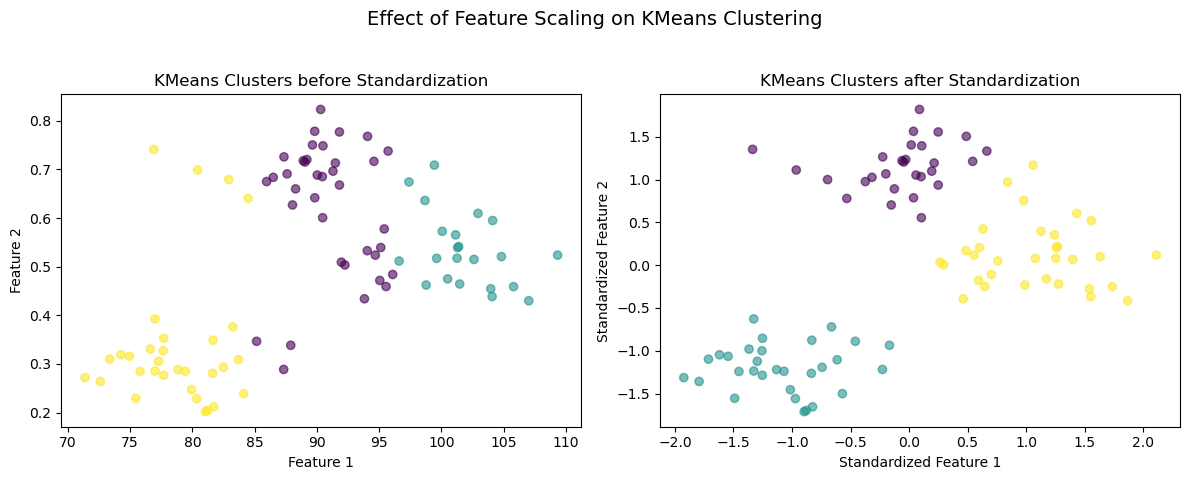

In [9]:
#@ title Demonstration of Feature Scaling on KMeans Clustering

# --- Generate Synthetic Data with Distinct Clouds ---
np.random.seed(random_seed)
n_points = 30
centers = [(80, 0.3), (90, 0.7), (100, 0.5)]
clusters = []
for cx, cy in centers:
    cluster = np.random.normal(loc=(cx, cy), scale=(5, 0.05), size=(n_points, 2))
    clusters.append(cluster)
features = np.vstack(clusters)

# --- KMeans on Raw Data ---
kmeans_raw = KMeans(n_clusters=3, random_state=random_seed).fit(features)
labels_raw = kmeans_raw.labels_

# --- Standardize Features ---
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# --- KMeans on Standardized Data ---
kmeans_scaled = KMeans(n_clusters=3, random_state=random_seed).fit(features_scaled)
labels_scaled = kmeans_scaled.labels_

# --- Plotting ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Before Standardization
axs[0].scatter(features[:, 0], features[:, 1], c=labels_raw, alpha=0.6)
axs[0].set_title('KMeans Clusters before Standardization')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')

# After Standardization
axs[1].scatter(features_scaled[:, 0], features_scaled[:, 1], c=labels_scaled, alpha=0.6)
axs[1].set_title('KMeans Clusters after Standardization')
axs[1].set_xlabel('Standardized Feature 1')
axs[1].set_ylabel('Standardized Feature 2')

plt.suptitle('Effect of Feature Scaling on KMeans Clustering', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In the following code cell, we standardize the feature matrix using `sklearn.preprocessing.StandardScaler`. This will ensure that each feature has a mean of 0 and a standard deviation of 1, making them comparable in the clustering process.

In [10]:
scaler = StandardScaler() # Initialize StandardScaler
scaled_arr = scaler.fit_transform(feature_df) # Fit and transform the feature DataFrame
scaled_df = pd.DataFrame(scaled_arr, index=feature_df.index, columns=feature_df.columns) # Create a new DataFrame with scaled values

scaled_df.head()

,mean,std,skew,kurtosis,autocorr_lag1,autocorr_lag24,midday_dip,evening_ramp,night_day_ratio,weekend_load_factor,peak_to_avg,longest_above_mean,longest_increase_streak
Meter_ID,,,,,,,,,,,,,
1169,0.524686,0.272613,-0.955345,-0.487109,0.481515,-0.677256,0.154286,-0.943461,-0.277718,-0.876863,-0.859716,-0.214896,1.088034
464,-0.111784,-0.414543,-0.750974,-0.390396,0.318548,1.002066,-0.360657,0.210468,-0.005514,-0.181564,-0.895355,1.116875,2.603401
699,0.134922,0.402526,-1.046707,-0.547716,1.504445,1.913792,-1.326909,0.522727,2.374520,-1.493357,-0.884493,-0.189873,-1.185017
527,-0.030495,0.079859,-0.347116,-0.287076,0.396247,-0.457402,0.360831,0.125057,-0.189332,-0.796282,-0.173303,-0.237139,-1.185017
146,-0.971728,-0.818056,0.563769,0.266573,-3.057545,-0.655860,0.150004,-0.055294,-0.102484,-0.614898,0.473841,-0.301086,-1.185017


### 5.3 t-SNE Visualization

Project the high-dimensional feature space into 2D to explore natural groupings. For this, we use t-SNE with a perplexity of 30 and 1000 iterations. This will help us visualize the structure of the data and identify potential clusters. To read more about t-SNE, you can refer to the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) or here in a [medium article](https://medium.com/data-science/t-sne-clearly-explained-d84c537f53a).

This doesn't give us clusters directly, but it helps us see how the data points are distributed in a lower-dimensional space. And maybe you can already spot some clusters visually?


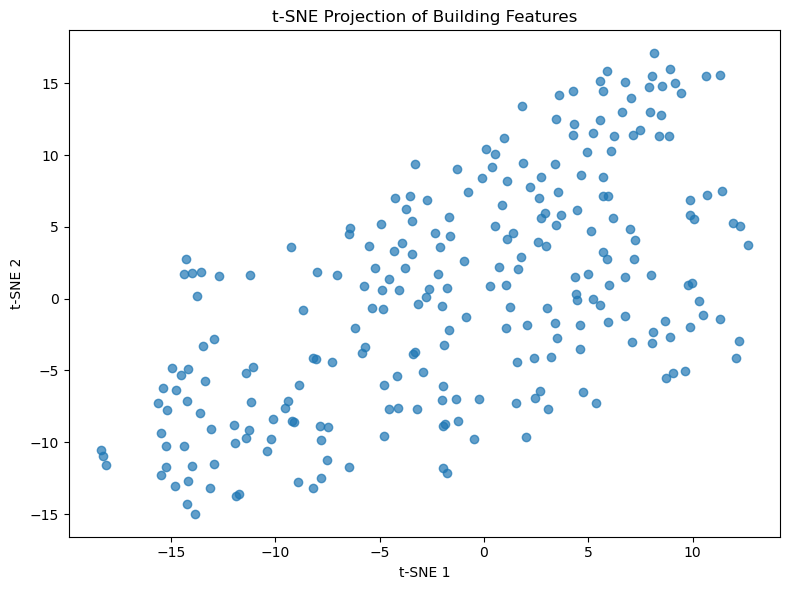

In [11]:
tsne = TSNE(n_components=2, random_state=random_seed)
coords = tsne.fit_transform(scaled_df)

plt.figure(figsize=(8,6))
plt.scatter(coords[:,0], coords[:,1], alpha=0.7)
plt.title("t-SNE Projection of Building Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

## 5.4 Principal Component Analysis (PCA)

PCA is a **linear** dimensionality‐reduction technique that finds a new orthogonal basis maximizing the variance in the data. In practice:

1. **Purpose**  
   - Reduce high-dimensional data to 2D for visualization.  
   - Quantify how much variance each principal component (PC) captures.

2. **Why It Matters**  
   - Unlike t-SNE (which excels at revealing local clusters), PCA gives a **global** picture of variance structure.  
   - Pre-processing with PCA can denoise data and speed up downstream methods (e.g. t-SNE, clustering).

> **Tip:** Always inspect the `explained_variance_ratio_` to see how much “signal” you’re retaining.


PC1 explains 34.5% variance; PC2 explains 16.0%


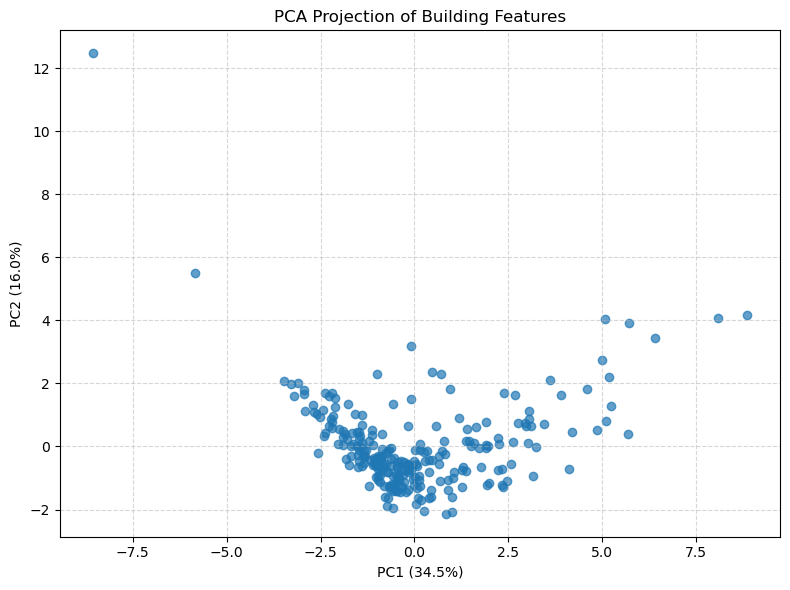

In [12]:
# Perform PCA on the scaled data
pca = PCA(n_components=2, random_state=random_seed)
pca_coords = pca.fit_transform(scaled_df)

# Print explained variance
explained = pca.explained_variance_ratio_
print(f"PC1 explains {explained[0]:.1%} variance; PC2 explains {explained[1]:.1%}")

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(pca_coords[:,0], pca_coords[:,1], alpha=0.7)
plt.title("PCA Projection of Building Features")
plt.xlabel(f"PC1 ({explained[0]:.1%})")
plt.ylabel(f"PC2 ({explained[1]:.1%})")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## 6. Clustering with K-Means

Clustering using K-Means is a powerful way to group similar load profiles. We will explore how many clusters to use by evaluating silhouette scores across different values of `k`. We will also use the inertia to help us determine the optimal number of clusters. The difference between inertia and silhouette score is that inertia measures how tightly the clusters are packed, while silhouette score measures how well-separated the clusters are.

For clustering, we will use the `KMeans` algorithm from `sklearn.cluster`. We will loop over a range of `k` values (2 to 8) and compute the silhouette score for each. The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters. A higher silhouette score indicates better-defined clusters.

After the clustering, we will visualize the clusters using t-SNE to see how well the K-Means algorithm has grouped the data points.

### 6.1 Exercise 2: K-Means Clustering and Scoring
In this exercise, you will implement K-Means clustering and evaluate the results using silhouette scores:

1. Loop over `k = 2…8`.  
2. For each `k`, fit a `KMeans(n_clusters=k, random_state=random_seed)` model on your **scaled** feature matrix.  
3. Compute the silhouette score with `silhouette_score(X, labels)`.  
4. Compute the inertia with `kmeans.inertia_`.
5. Collect all scores in a list and print them.
6. Plot the silhouette scores and inertia against `k` to visualize the “elbow” and identify the optimal number of clusters.

Hints:  
- Use `sklearn.cluster.KMeans` to get `labels = kmeans.fit_predict(...)`.  
- Use `sklearn.metrics.silhouette_score` to evaluate.  
- You can visualize the “elbow” by plotting `ks` on the x-axis and your score list on the y-axis.

In [13]:
silhouette_scores = []
inertia_scores = []
ks = range(2, 9)

for k in ks:
    # 1) Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=random_seed)
    labels = kmeans.fit_predict(scaled_df)
    
    # 2) Compute silhouette score
    score = silhouette_score(scaled_df, labels)
    silhouette_scores.append(score)

    # 3) Compute inertia
    inertia_scores.append(kmeans.inertia_)
    
    print(f"k={k}, silhouette_score={score:.4f}")

k=2, silhouette_score=0.3498
k=3, silhouette_score=0.2056
k=4, silhouette_score=0.1711
k=5, silhouette_score=0.1808
k=6, silhouette_score=0.1919
k=7, silhouette_score=0.1940
k=8, silhouette_score=0.1792


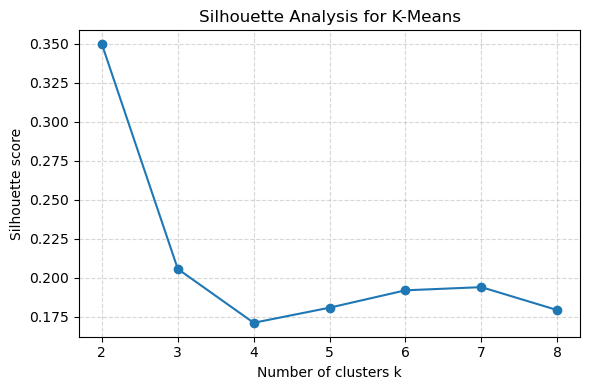

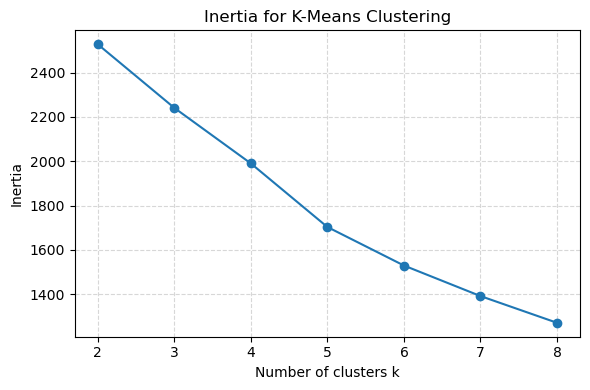

In [14]:
# Plot silhouette vs. k
plt.figure(figsize=(6,4))
plt.plot(list(ks), silhouette_scores, marker='o', linestyle='-')
plt.xticks(list(ks))
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Analysis for K-Means')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot inertia vs. k
plt.figure(figsize=(6,4))
plt.plot(list(ks), inertia_scores, marker='o', linestyle='-')
plt.xticks(list(ks))
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Inertia for K-Means Clustering')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Now let's visualize the clusters using t-SNE. This will help us see how well the K-Means algorithm has grouped the data points. We will use two clusters for simplicity, but you can experiment with more clusters if you like.

KMeans (k=2) silhouette: 0.350


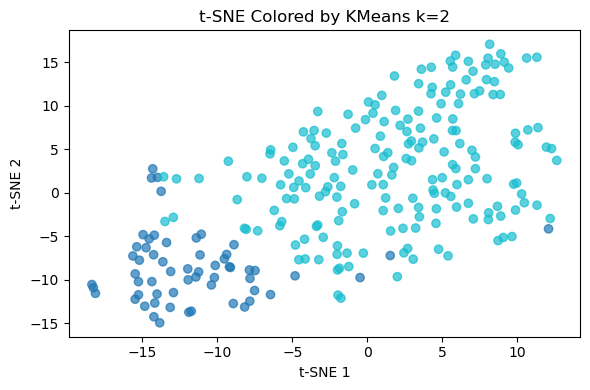

In [15]:
# K-Means with k=2
kmeans = KMeans(n_clusters=2, random_state=random_seed)
km_labels = kmeans.fit_predict(scaled_df)

# silhouette score
score = silhouette_score(scaled_df, km_labels)
print(f"KMeans (k=2) silhouette: {score:.3f}")

# t-SNE scatter colored by KMeans labels
plt.figure(figsize=(6,4))
plt.scatter(coords[:,0], coords[:,1], c=km_labels, cmap='tab10', alpha=0.7)
plt.title("t-SNE Colored by KMeans k=2")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


## 7. Agglomerative Clustering (Ward)

We apply hierarchical clustering with Ward linkage for $k=2$, compare silhouette and visualize on t-SNE.

To do this, we will use the `AgglomerativeClustering` class from `sklearn.cluster`. This class allows us to perform hierarchical clustering using different linkage criteria. We will use the Ward method, which minimizes the variance of clusters being merged.


Ward (k=2) silhouette: 0.303


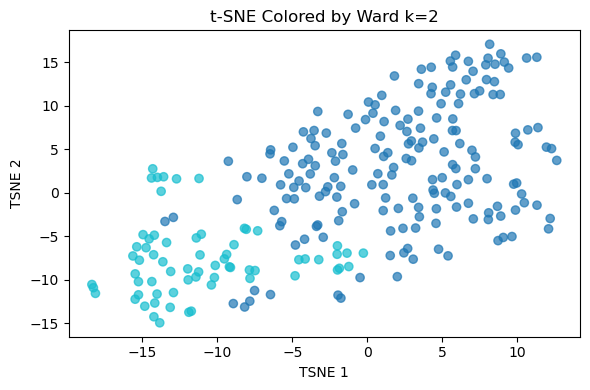

In [16]:
# Agglomerative Clustering with Ward linkage with k=2
ward = AgglomerativeClustering(n_clusters=2, linkage='ward')
agg_labels = ward.fit_predict(scaled_df)
score = silhouette_score(scaled_df, agg_labels)
print(f"Ward (k=2) silhouette: {score:.3f}")

plt.figure(figsize=(6,4))
plt.scatter(coords[:,0], coords[:,1], c=agg_labels, cmap='tab10', alpha=0.7)
plt.title(f"t-SNE Colored by Ward k=2")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.tight_layout()
plt.show()

## 8. Cluster Interpretation

Examine average feature values per cluster to infer DER presence. Do this for both the K-Means and Agglomerative clusters. This will help us understand the characteristics of each cluster and how they relate to DER presence.

>Note: Pay attention to the same values as we have identified in the lecture.

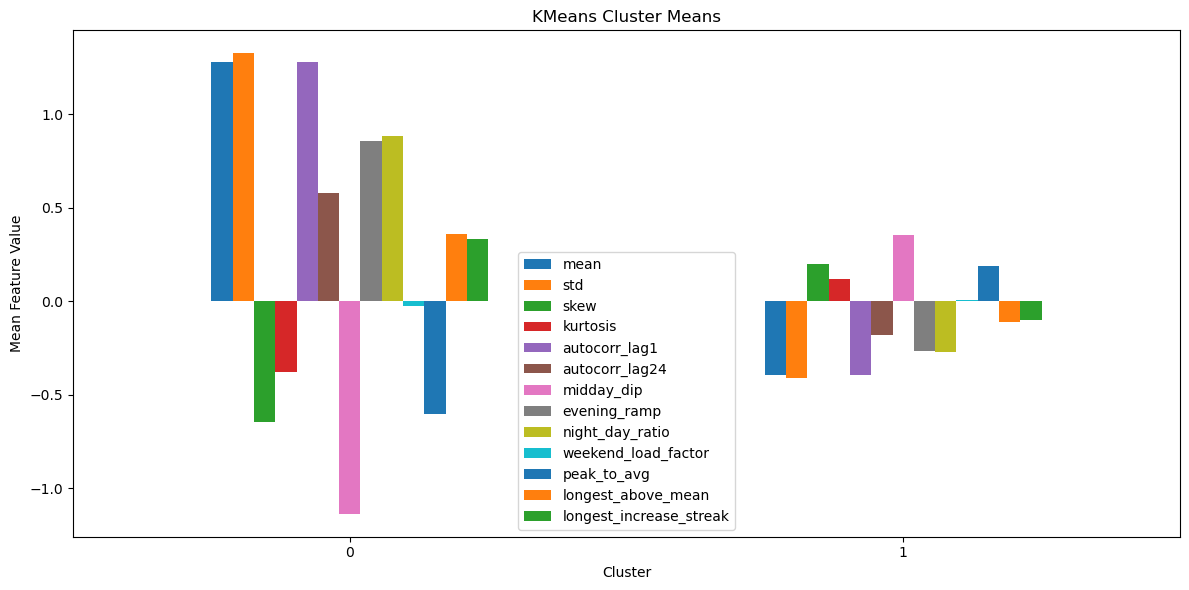

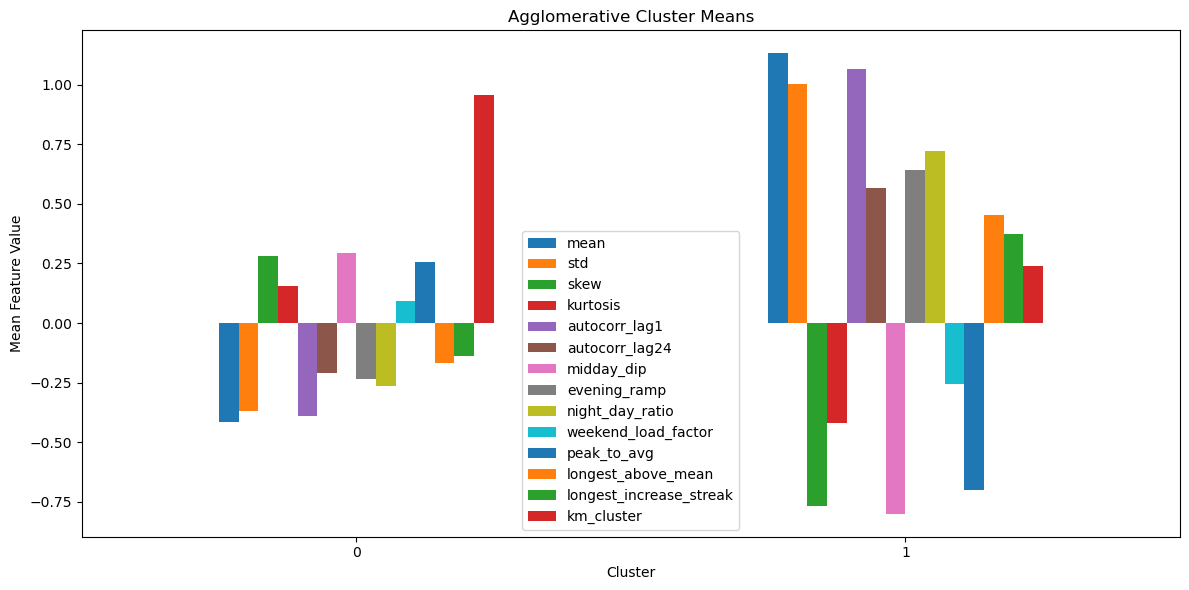

In [17]:
# take the original feature DataFrame and add cluster labels
clustered = scaled_df.copy()

# KMeans with k=2
clustered['km_cluster'] = km_labels
cluster_means = clustered.groupby('km_cluster').mean()

# plot KMeans cluster means
cluster_means.plot(kind='bar', figsize=(12, 6))
plt.title("KMeans Cluster Means")
plt.xlabel("Cluster")
plt.ylabel("Mean Feature Value")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Agglomerative with k=2
clustered['agg_cluster'] = agg_labels
agg_cluster_means = clustered.groupby('agg_cluster').mean()

# plot Agglomerative cluster means
agg_cluster_means.plot(kind='bar', figsize=(12, 6))
plt.title("Agglomerative Cluster Means")
plt.xlabel("Cluster")
plt.ylabel("Mean Feature Value")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 9. Assign and Evaluate Your Clusters

Now that you’ve explored and clustered your buildings, your final task is to **decide which cluster** corresponds to pure Baseline consumers and which one to EV-Only households. Write down your cluster assumptions and run the evaluation code below to see how well your clustering matches the true categories.

- **Step 1:** Inspect the t-SNE and feature summaries to decide which cluster corresponds to Baseline and which to EV-Only.
- **Step 2:** Plug your mapping into the code and run to compute overall accuracy and view the confusion matrix.  
- **Step 3:** Reflect on any mis-classified meters—what drove the errors, and how might you improve your features or clustering?  


### 9.1 Evaluation Utilities: Cluster Assignment Accuracy

To avoid duplicating code, we define a reusable function that evaluates your clustering results against ground-truth labels. You simply pass in:

- `cluster_series`: a pandas Series of predicted cluster IDs (indexed by Meter_ID)  
- `true_labels`: the ground-truth Series of meter categories (`Baseline`, `EV_Only`)  
- `cluster_to_label`: a dictionary mapping your cluster IDs to the actual label names

The function computes:

- Accuracy  
- Confusion matrix  
- Classification report


In [18]:
def evaluate_clustering(cluster_series, true_labels, cluster_to_label, method_name="Clustering"):
    """
    Evaluate a clustering against true labels.
    
    Parameters:
    - cluster_series: pd.Series of cluster IDs (indexed by Meter_ID)
    - true_labels: pd.Series of true labels (indexed by Meter_ID)
    - cluster_to_label: dict mapping {cluster_id: "Category_Label"}
    - method_name: str for display title
    """
    # Map cluster IDs to predicted category labels
    predicted_labels = cluster_series.map(cluster_to_label)
    
    # Align and mask
    y_true = true_labels.reindex(predicted_labels.index)
    y_pred = predicted_labels
    mask = y_true.notna()

    # Accuracy
    accuracy = (y_pred[mask] == y_true[mask]).mean()
    print(f"\n{method_name} Accuracy (on {mask.sum()} labeled meters): {accuracy*100:.2f}%\n")

    # Confusion Matrix
    conf = pd.crosstab(y_pred[mask], y_true[mask],
                       rownames=[f"Predicted ({method_name})"], colnames=["True"])
    print(f"Confusion Matrix ({method_name}):")
    print(conf)

    # Classification Report
    print(f"\nClassification Report ({method_name}):")
    print(classification_report(y_true[mask], y_pred[mask], zero_division=0))

We will also download the ground truth labels from the GitHub repository. This will allow us to evaluate our clustering results against the true categories of Baseline and EV-Only households.

In [19]:
# 1) Define the URL to the raw CSV on GitHub and the local path
url = 'https://raw.githubusercontent.com/nick-harder/AIES/main/lecture10/data/sample_smart_meter_labels.csv'
local_path = 'inputs/sample_smart_meter_labels.csv'

# 3) Download the file only if it's not already present
if not os.path.exists(local_path):
    print(f"Downloading data from {url} ...")
    urllib.request.urlretrieve(url, local_path)
    print("Download complete.")
else:
    print("File already exists, skipping download.")

# Load true labels if not already loaded
true_labels = pd.read_csv("inputs/sample_smart_meter_labels.csv", index_col="Meter_ID")["Category_Label"]


Download complete.


## 9.2 Exercise 3: Decide Cluster Assignments and Evaluate

In this exercise, you will assign your clusters to the Baseline and EV-Only categories and evaluate the results:

1. **Decide which cluster corresponds to Baseline and which to EV-Only** based on your analysis of the t-SNE plot and feature summaries.
2. **Update Cluster Maps** to your cluster assignments in the below code cells. 
3. **Run the evaluation function** with your cluster assignments and the ground-truth labels to compute accuracy and confusion matrix.
4. **Reflect on the results**: How well did your clustering match the true categories? What were the main sources of error? How might you improve your feature extraction or clustering approach in the future?

### 9.2.1 Evaluate K-Means Results

In [27]:
# check if all meter ids in true_labels are also in the feature_df
missing_meters = true_labels.index.difference(feature_df.index)
if not missing_meters.empty:
    print(f"Warning: {len(missing_meters)} Meter IDs in true_labels not found in feature_df:")
    print(missing_meters.tolist())

[13, 18, 34, 37, 38, 42, 48, 55, 67, 76, 77, 106, 121, 158, 162, 165, 173, 189, 191, 196, 203, 221, 230, 234, 238, 239, 256, 298, 301, 311, 316, 319, 329, 336, 337, 351, 371, 372, 386, 390, 391, 413, 416, 428, 441, 446, 454, 458, 472, 495, 519, 558, 561, 562, 563, 584, 589, 598, 612, 618, 624, 639, 645, 661, 680, 743, 770, 792, 874, 882, 902, 932, 940, 962, 963, 984, 993, 1039, 1042, 1092, 1115, 1150, 1164, 1171, 1172, 1177, 1226, 1231, 1241, 1247, 1256, 1261, 1293]


In [20]:
# Define your K-Means cluster mapping
cluster_map_km = {
    0: "Baseline",
    1: "EV_Only"
}

# Evaluate
evaluate_clustering(clustered["km_cluster"], true_labels, cluster_map_km, method_name="K-Means")


K-Means Accuracy (on 157 labeled meters): 9.55%

Confusion Matrix (K-Means):
True                 Baseline  EV_Only
Predicted (K-Means)                   
Baseline                   12       20
EV_Only                   122        3

Classification Report (K-Means):
              precision    recall  f1-score   support

    Baseline       0.38      0.09      0.14       134
     EV_Only       0.02      0.13      0.04        23

    accuracy                           0.10       157
   macro avg       0.20      0.11      0.09       157
weighted avg       0.32      0.10      0.13       157



### 9.2.2 Evaluate Agglomerative Clustering Results

In [21]:
# Define your Agglomerative cluster mapping
cluster_map_ward = {
    0: "Baseline", 
    1: "EV_Only"
}

# Evaluate
evaluate_clustering(clustered["agg_cluster"], true_labels, cluster_map_ward, method_name="Agglomerative")



Agglomerative Accuracy (on 157 labeled meters): 84.71%

Confusion Matrix (Agglomerative):
True                       Baseline  EV_Only
Predicted (Agglomerative)                   
Baseline                        114        4
EV_Only                          20       19

Classification Report (Agglomerative):
              precision    recall  f1-score   support

    Baseline       0.97      0.85      0.90       134
     EV_Only       0.49      0.83      0.61        23

    accuracy                           0.85       157
   macro avg       0.73      0.84      0.76       157
weighted avg       0.90      0.85      0.86       157



## 10. Summary and Conclusions

This notebook guided you through a complete workflow for identifying patterns in household electricity consumption using unsupervised learning techniques. The goal was to cluster buildings based on their load profiles and uncover behavioral patterns such as the presence of electric vehicles or photovoltaic systems.

---

### Concepts and Skills Covered

1. Data Exploration and Preprocessing
- You loaded high-frequency smart meter data and visualized consumption over time for individual buildings.
- You addressed missing values and ensured time alignment for analysis.

2. Feature Engineering
- You computed both domain-agnostic features (mean, standard deviation, skewness, kurtosis, autocorrelation) and domain-informed features (midday dip, evening ramp, weekend load factor, etc.).
- This dual approach enabled you to capture both statistical patterns and application-specific energy usage characteristics.

3. Dimensionality Reduction with t-SNE
- You used t-SNE to visualize the high-dimensional feature space in two dimensions.
- This allowed you to qualitatively assess whether natural groupings existed in the data.

4. Clustering
- You implemented and evaluated K-Means and Agglomerative (Ward) clustering.
- Silhouette scores and t-SNE visualizations helped assess cluster quality and separation.

5. Evaluation and Interpretation
- You compared your predicted clusters against labeled ground-truth categories.
- By analyzing confusion matrices and classification reports, you quantified how well your unsupervised methods aligned with known DER patterns.
- You reflected on how specific features contributed to cluster separation and what characteristics define each group.

---

### What You Have Learned

- How to engineer effective features from raw time series data
- The importance of both statistical and domain-specific insights when preparing data
- How to apply and compare different clustering techniques
- How to interpret clustering outputs in the context of real-world systems
- How to validate unsupervised learning results using labeled metadata

---

### Next Steps

In the final section, you were invited to analyze cluster behavior and assign real-world interpretations based on feature characteristics. You also evaluated your clustering performance against known labels.

If you want to continue learning and improving:

- Experiment with new features (e.g., Fourier coefficients, ramp rates, injection patterns)
- Try different dimensionality reduction methods like PCA or UMAP
- Use other clustering methods such as DBSCAN or Gaussian Mixture Models
- Incorporate external data (e.g., weather, occupancy) into your feature set

This notebook should serve as a strong foundation for applying unsupervised learning in practical energy analytics settings.
